# Reproduction of fetal brain segmentation with HC18 dataset

Below code is example of reproducing fetal brain segmentation with HC18 dataset.

Dataset __HC18__ consist of 999 2D ultrasound images of fetal brain. Each image is 256x256 pixels and has corresponding annotation mask.

<img src="data/images/001_HC.png" width="256" height="256"/> <img src="data/images/001_HC_seg.png" width="256" height="256"/>

Data are randomly splitted for 3 sets: train, validation and test with 0.6:0.2:0.2 ratio.

Training process is performed with __Unet__ architecture. The process was supported by [PYMIC](https://github.com/HiLab-git/PyMIC) toolkit dedicated for medical image computing . Training process takes about 0.5 hour on GPU.


Example Unet architecture: 

<img src="data/images/unet.png" width =500/>

---
# Code implementation

### Imports

In [3]:
import pandas as pd

import numpy as np
from scipy import ndimage
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split

### Constans

In [6]:
# DECLARING CONSTANTS
RANDOM_STATE = 2023  # for spliting data into train, val, test

#  Path to the data directory
DATA_DIR = "data"

# Paths to the images directories
TRAIN_SET_DIR = "training_set"
TRAIN_SET_LABELS_DIR = "training_set_label"
TEST_SET_DIR = "test_set"
RESULT_DIR = "result"

# Path to the config directory
CONFIG_DIR = "config"

# Paths to the config files
FETAL_HC_ALL = "fetal_hc_all.csv"
FETAL_HC_TRAIN = "fetal_hc_train.csv"
FETA_HC_VAL = "fetal_hc_valid.csv"
FETAL_HC_TEST = "fetal_hc_test.csv"
FETAL_HC_TEST_GT_SEG = "fetal_hc_test_gt_seg.csv"


## Data preparation


In [51]:
def get_backgrouond(img: np.ndarray) -> np.ndarray:  # 2D or 3D
    if img.sum() == 0:
        print("the largest component is null")
        return img
    if len(img.shape) == 3:  # is 3D
        im_structure = ndimage.generate_binary_structure(3, 1)  # iterate structure
    elif len(img.shape) == 2:  # is 2D
        im_structure = ndimage.generate_binary_structure(2, 1)
    else:
        raise ValueError("the dimension number shoud be 2 or 3")
    labeled_array, _ = ndimage.label(img, im_structure)  # labeling
    assert labeled_array.max() == 2
    return np.asarray(labeled_array == 1, np.uint8)


def get_segmentation_masks(root: str) -> None:
    root = Path(root)
    train_set = root / TRAIN_SET_DIR
    target_dir = root / TRAIN_SET_LABELS_DIR
    target_dir.mkdir(exist_ok=True)

    file_paths = list(train_set.glob("*Annotation.png"))

    for file_path in tqdm(file_paths):
        image = Image.open(file_path)

        data = np.asarray(image)
        data = np.asarray(data == 0)
        data_bg = get_backgrouond(data)
        data_fg = np.asarray(1.0 - data_bg, np.uint8) * 255

        out_img = Image.fromarray(data_fg)

        out_name = file_path.name.replace("Annotation", "seg")
        out_name = target_dir / out_name

        out_img.save(out_name)

In [4]:
get_segmentation_masks(DATA_DIR)


100%|██████████| 999/999 [00:07<00:00, 127.15it/s]


In [52]:
def create_train_csv_files(root: str) -> None:
    root = Path(root)
    config = Path(CONFIG_DIR)

    all_names_file = config / FETAL_HC_ALL
    train_names_file = config / FETAL_HC_TRAIN
    valid_names_file = config / FETA_HC_VAL
    test_names_file = config / FETAL_HC_TEST

    images_dir = root / TRAIN_SET_DIR
    label_dir = root / TRAIN_SET_LABELS_DIR

    filenames = [str(path).replace(f"{DATA_DIR}/", "") for path in list(label_dir.iterdir())]
    images_paths = [str(path).replace(f"{DATA_DIR}/", "") for path in list(images_dir.glob("*HC.png"))]

    df_all = pd.DataFrame({"image": images_paths, "label": filenames})
    df_all.to_csv(all_names_file, index=False)

    df_train, df_test = train_test_split(df_all, test_size=0.2, random_state=RANDOM_STATE)
    df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=RANDOM_STATE)

    df_train.to_csv(train_names_file, index=False)
    df_valid.to_csv(valid_names_file, index=False)
    df_test.to_csv(test_names_file, index=False)

    df_gt_seg = pd.concat(
        [
            df_test["label"],
            df_test["label"].apply(lambda x: filename_without_seg(x)),
        ],
        axis=1,
    )
    df_gt_seg.columns = ["ground_truth", "segmentation"]
    df_gt_seg.to_csv(config / FETAL_HC_TEST_GT_SEG, index=False)


def filename_without_seg(file_name: str) -> str:
    file_name = file_name.replace("_seg", "")
    file_name = Path(file_name)
    return str(file_name.stem + file_name.suffix)


In [6]:
create_train_csv_files(DATA_DIR)

---

## Training process

### Config

In [6]:
!cat config/unet.cfg

[dataset]
# tensor type (float or double)
tensor_type = float

task_type = seg
root_dir  = data
train_csv = config/fetal_hc_train.csv
valid_csv = config/fetal_hc_valid.csv
test_csv  = config/fetal_hc_test.csv

train_batch_size = 4

# data transforms
train_transform = [Rescale, RandomCrop, RandomFlip, NormalizeWithMeanStd, LabelConvert, LabelToProbability]
valid_transform = [Rescale, NormalizeWithMeanStd, LabelConvert, LabelToProbability]
test_transform  = [Rescale, NormalizeWithMeanStd]

Rescale_output_size    = [256, 384]
RandomCrop_output_size = [224, 320]

RandomFlip_flip_depth  = False
RandomFlip_flip_height = True
RandomFlip_flip_width  = True

NormalizeWithMeanStd_channels = [0]

LabelConvert_source_list = [0, 255]
LabelConvert_target_list = [0, 1]

[network]
# this section gives parameters for network
# the keys may be different for different networks

# type of network
net_type = UNet2D

# number of class, required for segmentation task
class_num = 2

in_chns       = 1
feature_

---

### Train by pymic_train

In [7]:
!pymic_train config/unet.cfg

dataset tensor_type float
dataset task_type seg
dataset root_dir data
dataset train_csv config/fetal_hc_train.csv
dataset valid_csv config/fetal_hc_valid.csv
dataset test_csv config/fetal_hc_test.csv
dataset train_batch_size 4
dataset train_transform ['Rescale', 'RandomCrop', 'RandomFlip', 'NormalizeWithMeanStd', 'LabelConvert', 'LabelToProbability']
dataset valid_transform ['Rescale', 'NormalizeWithMeanStd', 'LabelConvert', 'LabelToProbability']
dataset test_transform ['Rescale', 'NormalizeWithMeanStd']
dataset rescale_output_size [256, 384]
dataset randomcrop_output_size [224, 320]
dataset randomflip_flip_depth False
dataset randomflip_flip_height True
dataset randomflip_flip_width True
dataset normalizewithmeanstd_channels [0]
dataset labelconvert_source_list [0, 255]
dataset labelconvert_target_list [0, 1]
network net_type UNet2D
network class_num 2
network in_chns 1
network feature_chns [16, 32, 64, 128, 256]
network dropout [0, 0, 0.0, 0.1, 0.2]
network bilinear False
network mul

### Generating masks by trained unet model for test purpouse

In [9]:
!mkdir -p result
!pymic_test config/unet.cfg


dataset tensor_type float
dataset task_type seg
dataset root_dir data
dataset train_csv config/fetal_hc_train.csv
dataset valid_csv config/fetal_hc_valid.csv
dataset test_csv config/fetal_hc_test.csv
dataset train_batch_size 4
dataset train_transform ['Rescale', 'RandomCrop', 'RandomFlip', 'NormalizeWithMeanStd', 'LabelConvert', 'LabelToProbability']
dataset valid_transform ['Rescale', 'NormalizeWithMeanStd', 'LabelConvert', 'LabelToProbability']
dataset test_transform ['Rescale', 'NormalizeWithMeanStd']
dataset rescale_output_size [256, 384]
dataset randomcrop_output_size [224, 320]
dataset randomflip_flip_depth False
dataset randomflip_flip_height True
dataset randomflip_flip_width True
dataset normalizewithmeanstd_channels [0]
dataset labelconvert_source_list [0, 255]
dataset labelconvert_target_list [0, 1]
network net_type UNet2D
network class_num 2
network in_chns 1
network feature_chns [16, 32, 64, 128, 256]
network dropout [0, 0, 0.0, 0.1, 0.2]
network bilinear False
network mul

### Evaluation of the segmentation results with average symmetric surface distance (ASSD)

In [10]:
!pymic_eval_seg config/evaluation.cfg

evaluation metric_list ['dice', 'assd']
evaluation label_list [255]
evaluation organ_name brain
evaluation ground_truth_folder_root data
evaluation segmentation_folder_root data/result
evaluation evaluation_image_pair ./config/fetal_hc_test_gt_seg.csv
394_HC.png [0.977590674690933]
479_HC.png [0.9839180333430537]
039_HC.png [0.9796922636230796]
096_HC.png [0.9550465005968519]
322_HC.png [0.9788450141583949]
507_2HC.png [0.9884632070369268]
761_HC.png [0.9774793879405542]
557_HC.png [0.9863382050325655]
673_2HC.png [0.9467456942317979]
282_HC.png [0.9783567269201974]
508_HC.png [0.9811104618094981]
254_HC.png [0.9740717085318678]
580_HC.png [0.9872264434731233]
690_HC.png [0.9783817892873474]
305_HC.png [0.9811226860752413]
133_HC.png [0.9686957858461968]
027_HC.png [0.9665277682939946]
738_HC.png [0.9799075010938393]
082_HC.png [0.9634063560685889]
646_HC.png [0.9866887906842715]
675_HC.png [0.9842237894896457]
680_HC.png [0.9854461263613222]
050_HC.png [0.975797223071035]
460_HC.png [

data/result/004_HC.png


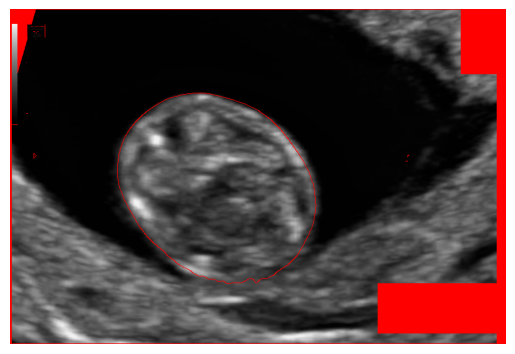

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Load the original image and the mask image
IMAGE_PATH = Path(DATA_DIR) / TRAIN_SET_DIR / "004_HC.png"
MASK_PATH = Path(DATA_DIR) / RESULT_DIR / IMAGE_PATH.name
display(f"Example segementation  MASK_PATH")
input_photo = cv2.imread(str(IMAGE_PATH))
segmentation_mask = cv2.imread(str(MASK_PATH), cv2.IMREAD_GRAYSCALE)

segmentation_mask = cv2.resize(segmentation_mask, (input_photo.shape[1], input_photo.shape[0]))

# Edge detection
edges = cv2.Canny(segmentation_mask, 30, 100)

# Combine inverted edges with input photo
inverted_edges = cv2.bitwise_not(edges)
output = cv2.bitwise_and(input_photo, input_photo, mask=inverted_edges)

# Outline on the output image
output[np.where((output == [0, 0, 0]).all(axis=2))] = [255, 0, 0]  # RGB

# Show the output image
plt.imshow(output)
plt.axis("off")
plt.show()